In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')
sys.path.append('/scratch/helfrech/Sync/GDrive/Projects/Zeolites_IZA-DEEM2/Scripts')

# Maths
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ML
from regression import PCovR, KPCovR, SparseKPCovR
from kernels import build_kernel, linear_kernel, gaussian_kernel
from kernels import center_kernel, center_kernel_fast
from kernels import center_kernel_oos, center_kernel_oos_fast
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.kernel_ridge import KernelRidge

# Utilities
import h5py
import json
from tqdm.notebook import tqdm
from project_utils import load_structures_from_hdf5
from selection import FPS

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
colorList = cosmostyle.color_cycle

In /home/helfrech/.config/matplotlib/stylelib/cosmo.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/helfrech/.config/matplotlib/stylelib/cosmoLarge.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


In [3]:
sys.path.append('/scratch/helfrech/Sync/GDrive/Projects/KPCovR/kernel-tutorials')
sys.path.append('/scratch/helfrech/Sync/GDrive/Projects/KPCovR/KernelPCovR/analysis/scripts')
#from utilities.classes import KPCovR as KPCovR2
#from utilities.classes import PCovR as PCovR2
from utilities.sklearn_covr.kpcovr import KernelPCovR as KPCovR2
from utilities.sklearn_covr.pcovr import PCovR as PCovR2
from helpers import l_regr, l_kpcovr

NOTE: there is variable name re-use between the different notebook "chapters". Each chapter should run independently, so it's probably a good idea to restart the kernel when moving between chapters

NOTE: all of the KPCovR fits will output a message saying no input data was provided -- this is b/c I haven't provided X data, but have provided a kernel, so it should still work as expected with the provided KPCovR utility. I have commented out the pieces in that utility that need X, since it's unnecessary here and doesn't play nicely with my keeping of structure-separated SOAP vectors as a list of arrays

NOTE: we throw out RWY since the KPCovR fitting will fail if RWY does not get assigned to the train set (ARPACK won't converge).

NOTE: per-component scaling of Y will give NaN if a property is all zero (which could be the case with one-hot encodings in this case, e.g., training on all IZA and testing on DEEM)

In [4]:
# TODO regress molar volume (KPCovR)

# Linear IZA+DEEM

## SVM

In [5]:
# Load train and test set indices
train_idxs = np.loadtxt('../Processed_Data/DEEM_10k/train.idxs', dtype=int)
test_idxs = np.loadtxt('../Processed_Data/DEEM_10k/test.idxs', dtype=int)

# Total number of structures
n_structures = train_idxs.size + test_idxs.size

In [6]:
# Load SOAP cutoffs
with open('../Processed_Data/soap_hyperparameters.json', 'r') as f:
    soap_hyperparameters = json.load(f)
    
cutoffs = soap_hyperparameters['interaction_cutoff']

In [7]:
# Load IZA cantons
cantons = np.loadtxt('../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
RWY = np.nonzero(cantons == 4)
cantons = np.delete(cantons, RWY)
n_iza = len(cantons)

In [8]:
cutoff = 6.0

# Load SOAPs
deem_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/soaps.hdf5'
deem_soaps = load_structures_from_hdf5(deem_file, datasets=None, concatenate=False)
deem_soaps_average = np.array([np.mean(soap, axis=0) for soap in deem_soaps])

iza_file = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/soaps.hdf5'
iza_soaps = load_structures_from_hdf5(iza_file, datasets=None, concatenate=False)
iza_soaps.pop(RWY[0][0])
iza_soaps_average = np.array([np.mean(soap, axis=0) for soap in iza_soaps])

In [9]:
# Subselections of train set and test set for Deem
# For IZA, just split structures 50/50
n_deem_train = 100 #2250
n_deem_test = 100 #None

deem_idxs = np.arange(0, train_idxs.size)
np.random.shuffle(deem_idxs)
deem_idxs_train = train_idxs[deem_idxs[0:n_deem_train]]

deem_idxs = np.arange(0, test_idxs.size)
np.random.shuffle(deem_idxs)
deem_idxs_test = test_idxs[deem_idxs[0:n_deem_test]]

In [10]:
n_iza_train = int(n_iza / 2)
n_iza_test = n_iza - n_iza_train
iza_idxs = np.arange(0, n_iza)
np.random.shuffle(iza_idxs)
iza_idxs_train = iza_idxs[0:n_iza_train]
iza_idxs_test = iza_idxs[n_iza_train:]

In [11]:
deem_train_svm = deem_soaps_average[deem_idxs_train, :]
deem_test_svm = deem_soaps_average[deem_idxs_test, :]

iza_train_svm = iza_soaps_average[iza_idxs_train, :]
iza_test_svm = iza_soaps_average[iza_idxs_test, :]

train_svm = np.vstack((iza_train_svm, deem_train_svm))
test_svm = np.vstack((iza_test_svm, deem_test_svm))

In [12]:
# Build the collection of soap vectors
# as a list of numpy arrays, where each list element
# corresponds do a structure
deem_train = [deem_soaps[i] for i in deem_idxs_train]
deem_test = [deem_soaps[i] for i in deem_idxs_test]

iza_train = [iza_soaps[i] for i in iza_idxs_train]
iza_test = [iza_soaps[i] for i in iza_idxs_test]

train = iza_train + deem_train
test = iza_test + deem_test

In [13]:
# Centering
train_svm_center = np.mean(train_svm, axis=0)
train_svm_centered = train_svm - train_svm_center
test_svm_centered = test_svm - train_svm_center

# Scaling
train_svm_scale = np.linalg.norm(train_svm_centered) / np.sqrt(train_svm_centered.shape[0])
train_svm_centered = train_svm_centered / train_svm_scale
test_svm_centered = test_svm_centered / train_svm_scale

In [14]:
print(np.trace(train_svm_centered @ train_svm_centered.T))

212.0


In [15]:
print(deem_idxs_train)
print(deem_idxs_test)

[ 501 1807  339 3928 8559 8490 2284 6835 5798 2253 1791 2568 9260 9045
 4198 7789 7352 5072 1133 5065 9521  196  966  495 6241 2824 2753 8696
 7461  896 8923 4825 1314 7403  821 6226 6890 2487 4943 4091 6121 1861
 8178 5639 6260 8583 5624 5602 6417 9379 1207 8340 9475 8557 4251 6221
 8654 3906 6464 4833 2095 2776 2811 6777  133 3739 2166  748 2058 8417
 2368  310 7632 6494 4168 1526 3372 3249 8594 6235 2591 7973 3143 8260
  757 7200 2716 9648 6056 5745 7735  621 5729 1800 3307 7073 6785 3671
 9968 6154]
[2674 4554 8721 9577 3417 8357 1712 3044 8294 7291 8123 6254 8094 2756
  496 9003 4875 7736 2023 8510 5750  421 5170 7103 6982 9843 6783 9106
 6021 1239 2657 1280 7459 1684 8629 3598 8460 9115 7122 4350 5431 3834
 5825 3792 7146 6928 8250 4193 9688 8555 4191 5326 3034 6808 7079 9366
 4624 8042 9821  716  139 3662 2546 1551 7552 7993 2596 3212 1005   61
 8430 2246 8805 7726 8334 1135 2380 5884 4044 7061 8402  505 5481 5797
 4441  348 2308 9496 7944 3504 4342 5576 2655 6311 9824 2306 1153

In [16]:
print(iza_idxs_train)
print(iza_idxs_test)

[185 171  55 223  92 134 151 201 158  95 209 224 129 178 120 117  17 183
 108  46 148 215 176 187  38 157 194   1  37  68 135 216 219 124  14 206
  24 199 220  86  43 126  59  74 145   0 106 193 109 130 140 166 181 195
  25  93  82  75  72 138 202 163 105 192  78 123 116 162  96  12 222  65
 131  29 200  41 100 168   2  34 154 217  62  84   3  73  70 175  27 218
 102 156   8 180  89  52 143  33 221 186  10  50  40 205  45 207  56  30
  35 204  94  97]
[210 159 169 127  49 147 115 184  44 150 110  21 111  32  79  64  36 189
 128  15 177  77 190  83  48 119  87   4 196 213  11 136 107  16 118 165
 179  85 172  90 153   6 170 137   7 121 161 155  60 212  28  88  42  54
 149 101  13 214  51  67 103 112 144  39 211  18 104  58  81 142 141  57
 139  80 191   9   5  53 114  47 152  63 160  31  66  61  76 167  20  98
 125  22 132  69 174  19  26 133  23  71 182 203 113 188 173  91 198 122
 208  99 146 164 197]


In [17]:
# Make classification labels for SVM
Y_svm_train = np.array(['IZA']*n_iza_train + ['DEEM']*n_deem_train)
Y_svm_test = np.array(['IZA']*n_iza_test + ['DEEM']*n_deem_test)

In [18]:
# SVM
lsvc = LinearSVC()
lsvc.fit(train_svm, Y_svm_train)

df_train = lsvc.decision_function(train_svm_centered)
df_test = lsvc.decision_function(test_svm_centered)

class_train = lsvc.predict(train_svm_centered)
class_test = lsvc.predict(test_svm_centered)

In [19]:
# Concatenate the "properties"
Y_train = np.reshape(df_train, (-1, 1))
Y_test = np.reshape(df_test, (-1, 1))

Y_mean = np.mean(df_train, axis=0)
Y_scale = np.linalg.norm(Y_train - Y_mean) / np.sqrt(Y_train.shape[0] / Y_train.shape[1])

Y_train = (Y_train - Y_mean) / Y_scale
Y_test = (Y_test - Y_mean) / Y_scale

## PCovR

In [20]:
pcovr = PCovR2(mixing=0.01, n_components=2, lr_args=dict(alpha=1.0), tol=1.0E-12, regularization=1.0E-12)
pcovr.fit(train_svm_centered, Y_train)
T_train = pcovr.transform(train_svm_centered)
Yp_train = pcovr.predict(train_svm_centered)
T_test = pcovr.transform(test_svm_centered)
Yp_test = pcovr.predict(test_svm_centered)

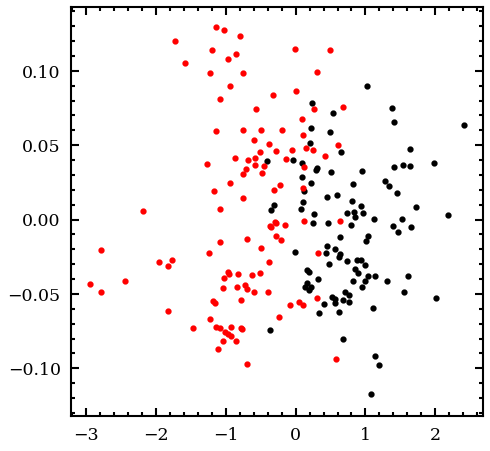

In [21]:
plt.scatter(T_train[n_iza_train:, 0], T_train[n_iza_train:, 1], c='k')
plt.scatter(T_train[0:n_iza_train, 0], T_train[0:n_iza_train, 1], c='r')
plt.show()

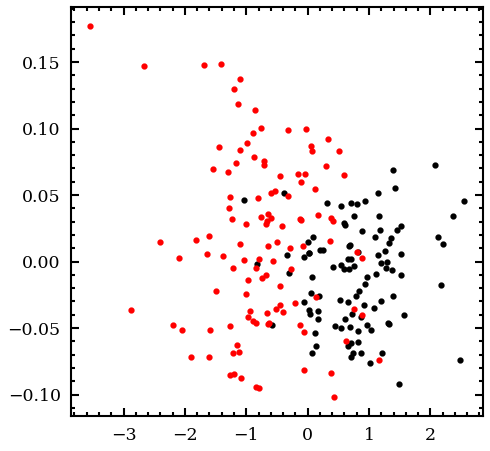

In [22]:
plt.scatter(T_test[n_iza_test:, 0], T_test[n_iza_test:, 1], c='k')
plt.scatter(T_test[0:n_iza_test, 0], T_test[0:n_iza_test, 1], c='r')
plt.show()

# Kernel IZA+DEEM

## Kernel SVM

In [23]:
# Load train and test set indices
train_idxs = np.loadtxt('../Processed_Data/DEEM_10k/train.idxs', dtype=int)
test_idxs = np.loadtxt('../Processed_Data/DEEM_10k/test.idxs', dtype=int)

# Total number of structures
n_structures = train_idxs.size + test_idxs.size

In [24]:
# Load SOAP cutoffs
with open('../Processed_Data/soap_hyperparameters.json', 'r') as f:
    soap_hyperparameters = json.load(f)
    
cutoffs = soap_hyperparameters['interaction_cutoff']

In [25]:
# Load IZA cantons
cantons = np.loadtxt('../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
RWY = np.nonzero(cantons == 4)
cantons = np.delete(cantons, RWY)
n_iza = len(cantons)
print(RWY)

(array([169]),)


In [26]:
cutoff = 6.0

# Load SOAPs
deem_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/soaps.hdf5'
deem_soaps = load_structures_from_hdf5(deem_file, datasets=None, concatenate=False)

iza_file = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/soaps.hdf5'
iza_soaps = load_structures_from_hdf5(iza_file, datasets=None, concatenate=False)
iza_soaps.pop(RWY[0][0])

array([[-0.00281038,  0.44229261,  0.12361648, ...,  0.00437123,
         0.00551277,  0.00056893],
       [-0.0028103 ,  0.44229261,  0.12361755, ...,  0.00437131,
         0.00551285,  0.00056887],
       [-0.00281031,  0.44229275,  0.1236168 , ...,  0.00437134,
         0.00551286,  0.0005689 ],
       ...,
       [-0.00281031,  0.44229311,  0.12361719, ...,  0.00437128,
         0.00551252,  0.00056898],
       [-0.00281059,  0.44229367,  0.12361391, ...,  0.00437097,
         0.00551275,  0.00056901],
       [-0.00281032,  0.44229303,  0.12361627, ...,  0.00437117,
         0.00551277,  0.00056894]])

In [27]:
# Subselections of train set and test set for Deem
# For IZA, just split structures 50/50
n_deem_train = 1000 #2250
n_deem_test = 1000 #None

deem_idxs = np.arange(0, train_idxs.size)
np.random.shuffle(deem_idxs)
deem_idxs_train = train_idxs[deem_idxs[0:n_deem_train]]

deem_idxs = np.arange(0, test_idxs.size)
np.random.shuffle(deem_idxs)
deem_idxs_test = test_idxs[deem_idxs[0:n_deem_test]]

#deem_idxs_train = train_idxs
#deem_idxs_test = test_idxs
#
#n_deem_train = len(train_idxs)
#n_deem_test = len(test_idxs)

In [28]:
#n_iza_train = int(0.7750 * n_iza)
n_iza_train = int(n_iza / 2)
n_iza_test = n_iza - n_iza_train
iza_idxs = np.arange(0, n_iza)
np.random.shuffle(iza_idxs)
iza_idxs_train = iza_idxs[0:n_iza_train]
iza_idxs_test = iza_idxs[n_iza_train:]

In [29]:
print(deem_idxs_train)
print(deem_idxs_test)

[1607 5284 6415 5510 4573 4631 7545 9570 8870 2025 3873 9521 3054 1078
  849 6718 3294 4846 8965 9034 2124 3073 7414 5925 5863 4405 8352 8454
 6710  416 3004 8266 2579 2870 9269 1072 2039 7933 8300 6396 7030 3047
 9386 5611  607 1132 5498 5963 8619 4040 1536 6682 4746 4570 1934 8239
 8004 4832 2842 3986 6903 4686 4244 3705 3427  604 7752 2835 2156 2737
 6048 7999 5168 1840 7198 2160 1112 2776 5915 2394 6172 7743 4794 3507
 7139 2038 3839 5839 6970  851  170 5717 6986 4100 3911 8681 4337 1063
 7385 3520 6404  249 9863  569 3103 9898 2557 8451 8099  161 8369 7403
 5900 8093 9920 3562  989 1110 5023 4456 2832 3716 5384 4657 5910 5944
 8347 3952 4593 9246 3865 1844 9305 2554 5558 7161 1936 7226 3461 5730
 1208 2610 1800 5714 9710 3268 7286 1491 9383 9068 4936 4797 8678 3352
 5734 4014 9312 7345 6377 9364 6820 8154 6762 7830 2550 5081 6323 2754
 5824 8882 2690 4987 2672 5704 3324 4530  413 5120  739 9733 2228 1960
 2952 8038 3526 4793 4062  659 2411 9693  449  527 1927 2779 4496 8609
 2175 

In [30]:
print(iza_idxs_train)
print(iza_idxs_test)

[209 222  50   3  21  79 126 158 131   6 101 138  81 121  65 124  27 200
 140  10  14 198  19  56 125 202  83 160 111 162 150  63 182 100 120 207
 224  12 164 130 206 153 132  53  41 204 199   0   8  55  22 117 179 156
  95  45  33  48  94 114 108 141  59  89  15 187 196 163 139 211 122 149
 133 113 157 155 142  17  42 173 165  26  37  43 180  86  47  20 154 213
 115 118  18 178 214 190 218 181 175  46  80 195  57  40 184  88 193  38
   5 217 103  54]
[145 172 219   2 171 167 169  39  76  25 147  70  62  82  98 123  78 191
  36  75   7  31  97  60 203 220 128 216 161  29 110 159 221 210 136  68
 197 102  99  58 135  87 168 109  96 215 119 186 104 143  16  72  90 137
  44 223  92 208  23  11  32  85  61  93 144   9  67 107 152  77  73   4
  64 127 189 188 116 205  84 170  35 177 192  24 212  28   1 134 151  69
  51  71  52  66 106  74 174 112 148 176 194 105 183 129  49 201  13  34
 185 166  91  30 146]


In [31]:
# Build the collection of soap vectors
# as a list of numpy arrays, where each list element
# corresponds do a structure
deem_train = [deem_soaps[i] for i in deem_idxs_train]
deem_test = [deem_soaps[i] for i in deem_idxs_test]

iza_train = [iza_soaps[i] for i in iza_idxs_train]
iza_test = [iza_soaps[i] for i in iza_idxs_test]

train = iza_train + deem_train
test = iza_test + deem_test

In [32]:
# Make classification labels for SVM
#Y_svm_train = np.array(['IZA']*n_iza_train + ['DEEM']*n_deem_train)
#Y_svm_test = np.array(['IZA']*n_iza_test + ['DEEM']*n_deem_test)

Y_svm_train = np.zeros(len(train), dtype=int)
Y_svm_train[0:n_iza_train] = cantons[iza_idxs_train]
Y_svm_train[n_iza_train:] = 4

Y_svm_test = np.zeros(len(test), dtype=int)
Y_svm_test[0:n_iza_test] = cantons[iza_idxs_test]
Y_svm_test[n_iza_test:] = 4

In [33]:
for i in np.arange(1, 5):
    print(np.count_nonzero(Y_svm_train == i))
    print(np.count_nonzero(Y_svm_test == i))

21
14
60
62
31
37
1000
1000


In [34]:
K_train = build_kernel(train, train, kernel='gaussian', gamma=10.0)
K_test = build_kernel(test, train, kernel='gaussian', gamma=10.0)
K_test_test = build_kernel(test, test, kernel='gaussian', gamma=10.0)

100%|██████████| 1113/1113 [06:04<00:00,  3.05it/s]


In [35]:
# Centering
K_test_test_centered = center_kernel_oos(K_test_test, K_test, K_train)
K_test_centered = center_kernel(K_test, K_ref=K_train)
K_train_centered = center_kernel(K_train)

# Scaling
K_scale = np.trace(K_train_centered) / np.shape(K_train_centered)[0]
K_test_test_centered /= K_scale
K_test_centered /= K_scale
K_train_centered /= K_scale

In [92]:
# SVM
# With 'balanced' class weights the predictions are a bit poorer, but the KPCovR projection
# looks largely the same
df_type = 'ovr'
svc = SVC(kernel='precomputed', decision_function_shape=df_type, class_weight='balanced', C=10.0)
svc.fit(K_train_centered, Y_svm_train)

df_train = svc.decision_function(K_train_centered)
df_test = svc.decision_function(K_test_centered)

class_svm_train = svc.predict(K_train_centered)
class_svm_test = svc.predict(K_test_centered)

In [93]:
print(svc.score(K_train_centered, Y_svm_train))
print(svc.score(K_test_centered, Y_svm_test))

0.9892086330935251
0.9380053908355795


In [94]:
# Concatenate the "properties"
#Y_train = np.reshape(df_train, (-1, 1))
#Y_test = np.reshape(df_test, (-1, 1))
Y_train = df_train
Y_test = df_test

In [95]:
Y_mean = np.mean(df_train, axis=0)
#Y_scale = np.linalg.norm(Y_train - Y_mean) / np.sqrt(Y_train.shape[0] / Y_train.shape[1])
Y_scale = np.linalg.norm(Y_train - Y_mean, axis=0) / np.sqrt(Y_train.shape[0] / Y_train.shape[1])

Y_train = (Y_train - Y_mean) / Y_scale
Y_test = (Y_test - Y_mean) / Y_scale

In [96]:
n_cols = Y_train.shape[1]

## Test regression on the SVM decision function

In [97]:
krr = KernelRidge(alpha=1.0E-12, kernel='precomputed')
krr.fit(K_train_centered, Y_train)
Yp_train = krr.predict(K_train_centered)
Yp_test = krr.predict(K_test_centered)

In [98]:
print(np.mean(np.abs(Yp_train - Y_train), axis=0))
print(np.mean(np.abs(Yp_test - Y_test), axis=0))

[1.06828570e-11 1.02063219e-11 8.10373249e-12 9.02630352e-12]
[0.22550227 0.23712307 0.20249712 0.1711846 ]


## KPCovR

In [99]:
# KPCovR parameters
alphas = np.linspace(0.0, 1.0, 11)
regs = np.logspace(-12, -1, 12)
n_kpcovr = 2

# Initialize matrices of losses
lrs_train = np.zeros((alphas.size, regs.size, n_cols))
lks_train = np.zeros((alphas.size, regs.size, n_cols))
lrs_test = np.zeros((alphas.size, regs.size, n_cols))
lks_test = np.zeros((alphas.size, regs.size, n_cols))
ltrs_train = np.zeros((alphas.size, regs.size))
ltks_train = np.zeros((alphas.size, regs.size))
ltrs_test = np.zeros((alphas.size, regs.size))
ltks_test = np.zeros((alphas.size, regs.size))

# Initialize matrices of classification accuracy
#class_kpcovr_train = np.zeros((alphas.size, regs.size))
#class_kpcovr_test = np.zeros((alphas.size, regs.size))

# CV indices
k_folds = 5
#k_idxs = np.arange(0, Y_train[0:112].shape[0]) # Only select IZA
k_idxs = np.arange(0, Y_train.shape[0])
np.random.shuffle(k_idxs)
k_idxs = np.array_split(k_idxs, k_folds) # Use array_split since train set size not divisible by k_folds
print([k.size for k in k_idxs])
print(k_idxs)

[223, 223, 222, 222, 222]
[array([ 476,  204,   14,  119,  131, 1017,  657,  203,   89,  979,  928,
        713,  447,  686,  911,  747,   49,  759, 1107,  365,  784,  555,
          1,   84,  569,  374,  375,   37, 1004,  367,  112,  325,  397,
        338,  227, 1092,  781,  282,  940,  667,  129, 1061, 1014,  396,
        216,  178,   94,  841,  174,  851,  150,  245,  580, 1075,  561,
         41,  404,  967,  308,  341,  908,  581,  229,  122,  433,  997,
        213,  401,  157,  231,  451,  268,  185,  415,   19,  490,  398,
        778,  827,   34,  610,  861,  615,  774,  531,  893,  677,  457,
        715,  421,  650,  305,  743,  738,   96,  701,  329,  532,  416,
        253,  449,  508, 1009,  497,  718,  699,   21,  589,  362,  359,
        373,  869,  304,  703,  586,  894, 1071,  763, 1079,  819,   83,
        921,  345,  945,  905,  926,  862,  857,  301,  964,  378, 1016,
       1001,  165,  987,  883, 1012,  462,  196,  803,  222, 1006,  989,
        516,  256,  376,

In [100]:
# Determine optimal alpha and regularization via cross validation
for adx, alpha in enumerate(tqdm(alphas)):
    for rdx, r in enumerate(tqdm(regs, leave=False)):
        for k in tqdm(range(0, k_folds), leave=False):
            k_idxs_train = k_idxs.copy()
            k_idxs_validate = k_idxs_train.pop(k)
            k_idxs_train = np.concatenate(k_idxs_train)
            
            # Set kernels and properties for the fold
            k_train = K_train[k_idxs_train, :][:, k_idxs_train]
            k_test = K_train[k_idxs_validate, :][:, k_idxs_train]
            k_test_test = K_train[k_idxs_validate, :][:, k_idxs_validate]
            y_train = Y_train[k_idxs_train, :]
            y_test = Y_train[k_idxs_validate, :]
            
            # Center and scale for the fold
            y_center = np.mean(y_train, axis=0)
            y_train_centered = y_train - y_center
            y_test_centered = y_test - y_center
            y_scale = np.linalg.norm(y_train_centered, axis=0) \
                / np.sqrt(y_train_centered.shape[0] / y_train_centered.shape[1])
            y_train_centered = y_train_centered / y_scale
            y_test_centered = y_test_centered / y_scale
            
            # Even though we have auto-centering and auto-scaling,
            # center and scale here for the loss functions
            k_test_test_centered = center_kernel_oos_fast(k_test_test, k_test, k_train)
            k_test_centered = center_kernel_fast(k_test, K_ref=k_train)
            k_train_centered = center_kernel_fast(k_train)
            k_scale = np.trace(k_train_centered) / k_train_centered.shape[0]
            k_test_test_centered = k_test_test_centered/k_scale
            k_test_centered = k_test_centered/k_scale
            k_train_centered = k_train_centered/k_scale

            # KPCovR fit and predictions
            # Already scaled, so omit here to speed things up
            kpcovr = KPCovR2(mixing=alpha, n_components=n_kpcovr, kernel='precomputed', 
                             krr_params=dict(alpha=r))
            #kpcovr = KPCovR(alpha=alpha, n_kpca=n_kpcovr, reg=r)
            kpcovr.fit(k_train_centered, y_train_centered)
            
            t_train = kpcovr.transform(k_train_centered) #kpcovr.transform_K(k_train_centered) #
            yp_train = kpcovr.predict(k_train_centered) #kpcovr.transform_Y(k_train_centered) #
            t_test = kpcovr.transform(k_test_centered) #kpcovr.transform_K(k_test_centered) #
            yp_test = kpcovr.predict(k_test_centered) #kpcovr.transform_Y(k_test_centered) #
            
            yp_train_centered = yp_train #(yp_train - y_center) / y_scale
            yp_test_centered = yp_test #(yp_test - y_center) / y_scale
            
            ### Just optimize based on IZA ###
            #iza_select_train = np.nonzero(k_idxs_train < n_iza_train)[0]
            #iza_select_test = np.nonzero(k_idxs_validate < n_iza_test)[0]
            #
            #y_train_centered = y_train_centered[iza_select_train]
            #y_test_centered = y_test_centered[iza_select_test]
            #y_train = y_train[iza_select_train]
            #y_test = y_test[iza_select_test]
            #yp_train = yp_train[iza_select_train]
            #yp_test = yp_test[iza_select_test]
            #yp_train_centered = yp_train_centered[iza_select_train]
            #yp_test_centered = yp_test_centered[iza_select_test]
            #k_train_centered = k_train_centered[iza_select_train, :][:, iza_select_train]
            #k_test_centered = k_test_centered[iza_select_test, :][:, iza_select_train]
            #k_test_test_centered = k_test_test_centered[iza_select_test, :][:, iza_select_test]
            #t_train = t_train[iza_select_train, :]
            #t_test = t_test[iza_select_test, :]
            ##################################
            
            # Collect regression and projection (KPCovR) losses for each canton
            lrs_test[adx, rdx, :] += l_regr(y_test_centered, yp_test_centered)
            lks_test[adx, rdx, :] += l_kpcovr(k_train=k_train_centered,
                                        k_test=k_test_centered,
                                        k_test_test=k_test_test_centered,
                                        t_train=t_train, t_test=t_test)#, 
                                        #pkt=kpcovr.pkt_, #[iza_select_train, :], ###
                                        #ptk=kpcovr.ptk_) #[:, iza_select_train]) ###

            lrs_train[adx, rdx, :] += l_regr(y_train_centered, yp_train_centered)
            lks_train[adx, rdx, :] += l_kpcovr(k_train=k_train_centered,
                                         t_train=t_train, t_test=t_test)#, 
                                         #pkt=kpcovr.ptk_, #[iza_select_train, :], ###
                                         #ptk=kpcovr.ptk_) #[:, iza_select_train]) ###

            # Total loss as sum of cantonwise losses
            ltrs_train[adx, rdx] += np.sum(lrs_train[adx, rdx, :])
            ltks_train[adx, rdx] += np.sum(lks_train[adx, rdx, :])

            ltrs_test[adx, rdx] += np.sum(lrs_test[adx, rdx, :])
            ltks_test[adx, rdx] += np.sum(lks_test[adx, rdx, :])
            
            # Convert to integer canton
            #y_true_train = np.argmax(y_train, axis=1) + 1
            #y_true_test = np.argmax(y_test, axis=1) + 1
            #
            #y_pred_train = np.argmax(yp_train, axis=1) + 1
            #y_pred_test = np.argmax(yp_test, axis=1) + 1
            #
            #class_kpcovr_train[adx, rdx] += np.count_nonzero(y_pred_train == y_true_train) / len(y_true_train)
            #class_kpcovr_test[adx, rdx] += np.count_nonzero(y_pred_test == y_true_test) / len(y_true_test)
         
        # Average over the folds
        lrs_test[adx, rdx, :] /= k_folds
        lks_test[adx, rdx, :] /= k_folds

        ltrs_test[adx, rdx] /= k_folds
        ltks_test[adx, rdx] /= k_folds

        lrs_train[adx, rdx, :] /= k_folds
        lks_train[adx, rdx, :] /= k_folds

        ltrs_train[adx, rdx] /= k_folds
        ltks_train[adx, rdx] /= k_folds
        
        #class_kpcovr_train[adx, rdx] /= k_folds
        #class_kpcovr_test[adx, rdx] /= k_folds

In [101]:
#data  =  np.load('kpcovr-svm_balancedweights.npz', allow_pickle=True)
#
#deem_idxs_train = data['deem_idxs_train']
#deem_idxs_test = data['deem_idxs_test']
#iza_idxs_train = data['iza_idxs_train']
#iza_idxs_test = data['iza_idxs_test']
#Y_svm_train = data['Y_svm_train']
#Y_svm_test = data['Y_svm_test']
#K_train = data['K_train']
#K_test = data['K_test']
#K_test_test = data['K_test_test']
#K_train_centered = data['K_train_centered']
#K_test_centered = data['K_test_centered']
#K_test_test_centered = data['K_test_test_centered']
#alphas = data['alphas']
#regs = data['regs']
#k_idxs = data['k_idxs']
#lrs_train = data['lrs_train']
#lks_train = data['lks_train']
#lrs_test = data['lrs_test']
#lks_test = data['lks_test']
#ltrs_train = data['ltrs_train']
#ltks_train = data['ltks_train']
#ltrs_test = data['ltrs_test']
#ltks_test = data['ltks_test']
#opt_alpha = data['opt_alpha']
#opt_reg = data['opt_reg']
#
#n_kpcovr = 2
#n_iza_train = len(iza_idxs_train)
#n_iza_test = len(iza_idxs_test)

In [102]:
# Extract optimal hyperparameters
#max_idx_test = np.unravel_index(np.argmax(class_kpcovr_test, axis=None), class_kpcovr_test.shape)
max_idx_test = np.unravel_index(np.argmin(ltrs_test+ltks_test, axis=None), (ltrs_test+ltks_test).shape)
opt_alpha_idx = max_idx_test[0]
opt_reg_idx = max_idx_test[1]
print(max_idx_test)
#print(class_kpcovr_test[max_idx_test], class_kpcovr_train[max_idx_test])
print(alphas[max_idx_test[0]], regs[max_idx_test[1]])
#print(class_kpcovr_test)

(8, 11)
0.8 0.1


In [103]:
opt_alpha = alphas[opt_alpha_idx]
opt_reg = regs[opt_reg_idx]

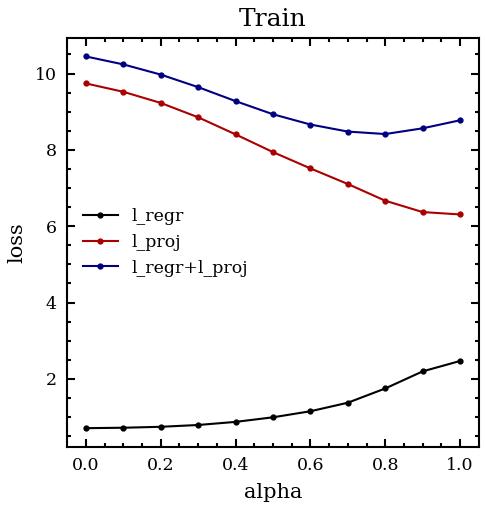

In [104]:
# Sum of projection and regression loss over all cantons for the train set
plt.plot(alphas, ltrs_train[:, opt_reg_idx], 'o-', label='l_regr')
plt.plot(alphas, ltks_train[:, opt_reg_idx], 'o-', label='l_proj')
plt.plot(alphas, ltrs_train[:, opt_reg_idx]+ltks_train[:, opt_reg_idx], 'o-', label='l_regr+l_proj')
plt.legend()
plt.title('Train')
plt.xlabel('alpha')
plt.ylabel('loss')
plt.show()

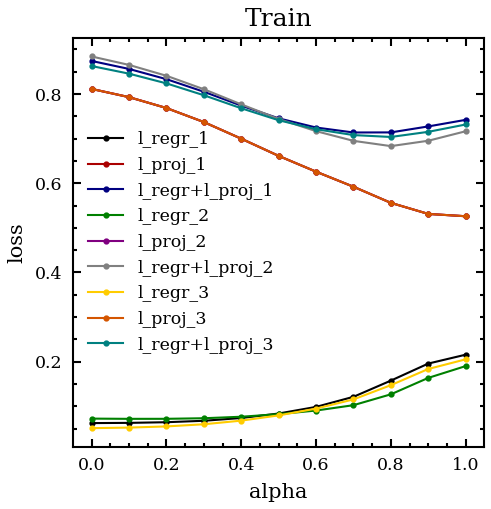

In [105]:
# Cantonwise losses for the train set
for i in range(0, 3):
    plt.plot(alphas, lrs_train[:, opt_reg_idx, i], 'o-', label=f'l_regr_{i+1}')
    plt.plot(alphas, lks_train[:, opt_reg_idx, i], 'o-', label=f'l_proj_{i+1}')
    plt.plot(alphas, lrs_train[:, opt_reg_idx, i]+lks_train[:, opt_reg_idx, i], 'o-', label=f'l_regr+l_proj_{i+1}')

plt.legend()
plt.title('Train')
plt.xlabel('alpha')
plt.ylabel('loss')
plt.show()

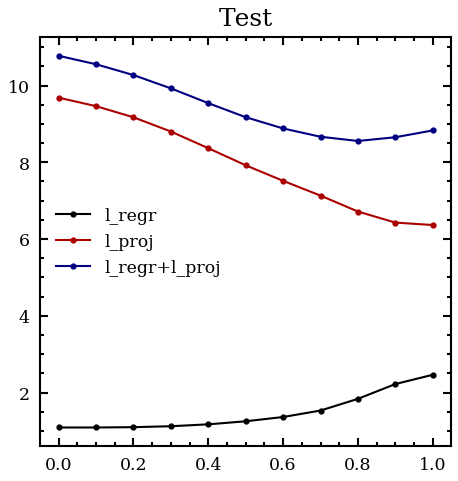

In [106]:
# Sum of projection and regression loss over all cantons for the test set
plt.plot(alphas, ltrs_test[:, opt_reg_idx], 'o-', label='l_regr')
plt.plot(alphas, ltks_test[:, opt_reg_idx], 'o-', label='l_proj')
plt.plot(alphas, ltrs_test[:, opt_reg_idx]+ltks_test[:, opt_reg_idx], 'o-', label='l_regr+l_proj')
plt.legend()
plt.title('Test')
plt.show()

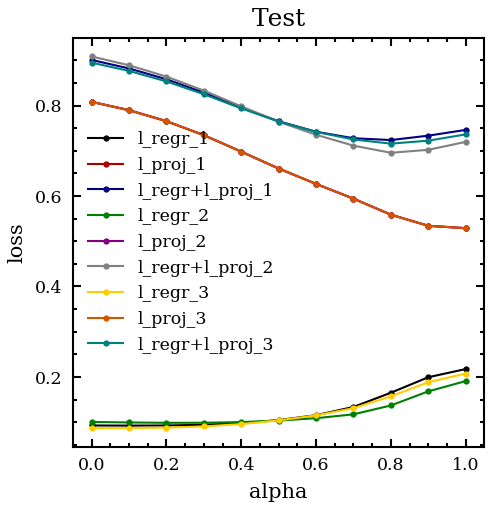

In [107]:
# Cantonwise losses for the train set
for i in range(0, 3):
    plt.plot(alphas, lrs_test[:, opt_reg_idx, i], 'o-', label=f'l_regr_{i+1}')
    plt.plot(alphas, lks_test[:, opt_reg_idx, i], 'o-', label=f'l_proj_{i+1}')
    plt.plot(alphas, lrs_test[:, opt_reg_idx, i]+lks_test[:, opt_reg_idx, i], 'o-', label=f'l_regr+l_proj_{i+1}')

plt.legend()
plt.title('Test')
plt.xlabel('alpha')
plt.ylabel('loss')
plt.show()

In [121]:
kpcovr = KPCovR2(mixing=0.0, n_components=n_kpcovr, kernel='precomputed', krr_params=dict(alpha=opt_reg))
#kpcovr = KPCovR(alpha=opt_alpha, n_kpca=n_kpcovr, reg=opt_reg)
kpcovr.fit(K_train_centered, Y_train)
T_train = kpcovr.transform(K_train_centered) #kpcovr.transform_K(K_train_centered) #
Yp_train = kpcovr.predict(K_train_centered) #kpcovr.transform_Y(K_train_centered) #
T_test = kpcovr.transform(K_test_centered) #kpcovr.transform_K(K_test_centered) #
Yp_test = kpcovr.predict(K_test_centered) #kpcovr.transform_Y(K_test_centered) #

In [122]:
Y_train

array([[-0.31832649, -0.11296083,  1.05444988, -0.57833004],
       [ 1.07957158,  1.3398872 , -0.90772159, -1.56018907],
       [ 1.16480957,  1.34294736, -0.92254753, -1.55030674],
       ...,
       [-0.31880078,  0.62576682, -0.33650093,  0.16056592],
       [ 0.29284291,  0.47019032, -0.88896206,  0.15652837],
       [-0.32550337, -0.17050231,  0.25512639,  0.16778967]])

In [123]:
Yp_train

array([[-0.43792524,  0.18865601,  0.48111546, -0.23924592],
       [ 0.92785621,  1.35782618, -0.8458289 , -1.40037852],
       [ 1.22021237,  1.60932846, -1.12975001, -1.65026528],
       ...,
       [ 0.0861331 ,  0.23332749, -0.06792582, -0.24641774],
       [ 0.42352975,  0.11409737, -0.43601917, -0.09043623],
       [-0.2744431 , -0.1836628 ,  0.27170168,  0.17767935]])

In [124]:
# Rescale to raw decision function
Yp_train = Yp_train * Y_scale + Y_mean
Yp_test = Yp_test * Y_scale + Y_mean

In [125]:
# Similar to sklearn transformation, see multiclass._ovr_decision_function (BSD 3-Clause License)
#df_type = 'ovr'
use_df_sums = True
n_classes = 4
if df_type == 'ovo':
    vote_matrix_train = np.zeros((Y_train.shape[0], n_classes))
    vote_matrix_test = np.zeros((Y_test.shape[0], n_classes))
    df_sum_train = np.zeros((Y_train.shape[0], n_classes))
    df_sum_test = np.zeros((Y_test.shape[0], n_classes))
        
    # Predicted class determined by majority vote
    col_idx = 0
    for i in range(0, n_classes):
        for j in range(i + 1, n_classes):
            col_train = Yp_train[:, col_idx]
            vote_matrix_train[col_train > 0, i] += 1
            vote_matrix_train[col_train <= 0, j] += 1
            
            col_test = Yp_test[:, col_idx]
            vote_matrix_test[col_test > 0, i] += 1
            vote_matrix_test[col_test <= 0, j] += 1
            
            # TODO: break ties with distances from hyperplane
            # Add value of decision function
            if use_df_sums:
                df_sum_train[:, i] += Yp_train[:, col_idx]
                df_sum_train[:, j] -= Yp_train[:, col_idx]
                
                df_sum_test[:, i] += Yp_test[:, col_idx]
                df_sum_test[:, j] -= Yp_test[:, col_idx]
            
            col_idx += 1
            
    if use_df_sums:
        transformed_df_sum_train = df_sum_train / (3 * (np.abs(df_sum_train) + 1))
        transformed_df_sum_test = df_sum_test / (3 * (np.abs(df_sum_test) + 1))
        
        vote_matrix_train += transformed_df_sum_train
        vote_matrix_test += transformed_df_sum_test

            
    class_kpcovr_train = np.argmax(vote_matrix_train, axis=1) + 1
    class_kpcovr_test = np.argmax(vote_matrix_test, axis=1) + 1
            
else:
    
    # Predicted class determined by largest (positive) value of the decision function
    class_kpcovr_train = np.argmax(Yp_train*Y_scale+Y_mean, axis=1) + 1
    class_kpcovr_test = np.argmax(Yp_test*Y_scale+Y_mean, axis=1) + 1

In [126]:
print(all(class_kpcovr_train == class_svm_train))
print(all(class_kpcovr_test == class_svm_test))

False
False


In [127]:
print(Y_svm_train)
print(class_kpcovr_train)
print(class_svm_train)

[3 2 2 ... 4 4 4]
[4 2 2 ... 4 4 4]
[3 2 2 ... 4 4 4]


In [128]:
print(Y_svm_test)
print(class_kpcovr_test)
print(class_svm_test)

[2 3 2 ... 4 4 4]
[2 3 4 ... 4 4 4]
[2 3 2 ... 4 4 4]


In [129]:
# Simple classification accuracy
train_accuracy = np.count_nonzero(class_kpcovr_train == Y_svm_train) / len(Y_svm_train)
test_accuracy = np.count_nonzero(class_kpcovr_test == Y_svm_test) / len(Y_svm_test)

print(train_accuracy)
print(test_accuracy)
print(classification_report(Y_svm_train, class_kpcovr_train))
print(classification_report(Y_svm_test, class_kpcovr_test))
print(confusion_matrix(Y_svm_train, class_kpcovr_train))
print(confusion_matrix(Y_svm_test, class_kpcovr_test))

0.9433453237410072
0.945193171608266
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        21
           2       0.67      0.77      0.71        60
           3       0.75      0.19      0.31        31
           4       0.96      1.00      0.98      1000

    accuracy                           0.94      1112
   macro avg       0.59      0.49      0.50      1112
weighted avg       0.92      0.94      0.93      1112

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        14
           2       0.66      0.79      0.72        62
           3       0.67      0.11      0.19        37
           4       0.97      1.00      0.98      1000

    accuracy                           0.95      1113
   macro avg       0.57      0.47      0.47      1113
weighted avg       0.93      0.95      0.93      1113

[[  0  13   0   8]
 [  0  46   2  12]
 [  0   7   6  18]
 [  0   3   0 997]]
[[  0  12   0   

/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [130]:
# Simple classification accuracy, DEEM only
train_accuracy = \
    np.count_nonzero(class_kpcovr_train[n_iza_train:] == Y_svm_train[n_iza_train:]) / len(Y_svm_train[n_iza_train:])
test_accuracy = \
    np.count_nonzero(class_kpcovr_test[n_iza_test:] == Y_svm_test[n_iza_test:]) / len(Y_svm_test[n_iza_test:])

print(train_accuracy)
print(test_accuracy)
print(classification_report(Y_svm_train[n_iza_train:], class_kpcovr_train[n_iza_train:], labels=[1, 2, 3, 4]))
print(classification_report(Y_svm_test[n_iza_test:], class_kpcovr_test[n_iza_test:], labels=[1, 2, 3, 4]))

0.997
0.999
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       1.00      1.00      1.00      1000

   micro avg       1.00      1.00      1.00      1000
   macro avg       0.25      0.25      0.25      1000
weighted avg       1.00      1.00      1.00      1000

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       1.00      1.00      1.00      1000

   micro avg       1.00      1.00      1.00      1000
   macro avg       0.25      0.25      0.25      1000
weighted avg       1.00      1.00      1.00      1000



/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [131]:
# Simple classification accuracy, IZA only
train_accuracy = \
    np.count_nonzero(class_kpcovr_train[0:n_iza_train] == Y_svm_train[0:n_iza_train]) / len(Y_svm_train[0:n_iza_train])
test_accuracy = \
    np.count_nonzero(class_kpcovr_test[0:n_iza_test] == Y_svm_test[0:n_iza_test]) / len(Y_svm_test[0:n_iza_test])

print(train_accuracy)
print(test_accuracy)
print(classification_report(Y_svm_train[0:n_iza_train], class_kpcovr_train[0:n_iza_train]))
print(classification_report(Y_svm_test[0:n_iza_test], class_kpcovr_test[0:n_iza_test]))

0.4642857142857143
0.4690265486725664
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        21
           2       0.70      0.77      0.73        60
           3       0.75      0.19      0.31        31
           4       0.00      0.00      0.00         0

    accuracy                           0.46       112
   macro avg       0.36      0.24      0.26       112
weighted avg       0.58      0.46      0.48       112

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        14
           2       0.67      0.79      0.73        62
           3       0.67      0.11      0.19        37
           4       0.00      0.00      0.00         0

    accuracy                           0.47       113
   macro avg       0.33      0.22      0.23       113
weighted avg       0.59      0.47      0.46       113



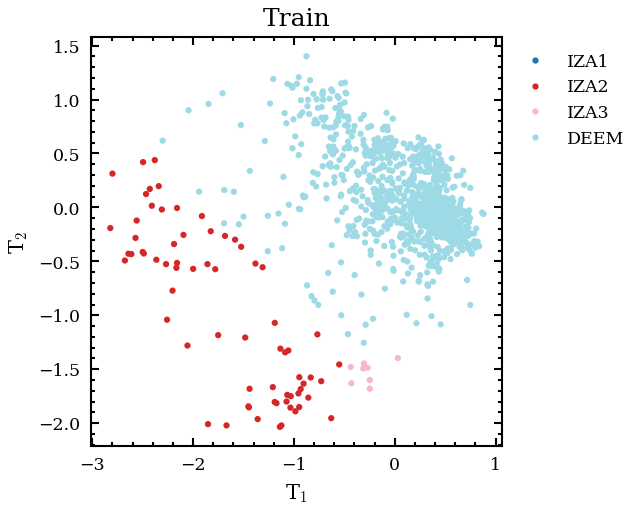

In [132]:
plt.scatter(T_train[n_iza_train:, 0], T_train[n_iza_train:, 1], 
            #c=Y_svm_train[n_iza_train:], cmap='tab20', vmin=1, vmax=4, zorder=2)
            c=class_kpcovr_train[n_iza_train:], cmap='tab20', vmin=1, vmax=4, zorder=2)
plt.scatter(T_train[0:n_iza_train, 0], T_train[0:n_iza_train, 1], 
            #c=Y_svm_train[0:n_iza_train], cmap='tab20', vmin=1, vmax=4, zorder=3)
            c=class_kpcovr_train[0:n_iza_train], cmap='tab20', vmin=1, vmax=4, zorder=3)
#plt.scatter(T_train[:, 0], T_train[:, 1], c=Y_svm_train, cmap='tab20')
handles = [Line2D([0], [0], c=plt.get_cmap('tab20')(0.0), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(0.33), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(0.67), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(1.0), marker='o', linewidth=0)]
labels = ['IZA1', 'IZA2', 'IZA3', 'DEEM']
plt.legend(handles=handles, labels=labels, loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.xlabel(r'T$_1$')
plt.ylabel(r'T$_2$')
plt.title('Train')

plt.savefig('../Results/6.0/svm-kpcovr-test_train.png', bbox_inches='tight')

plt.show()

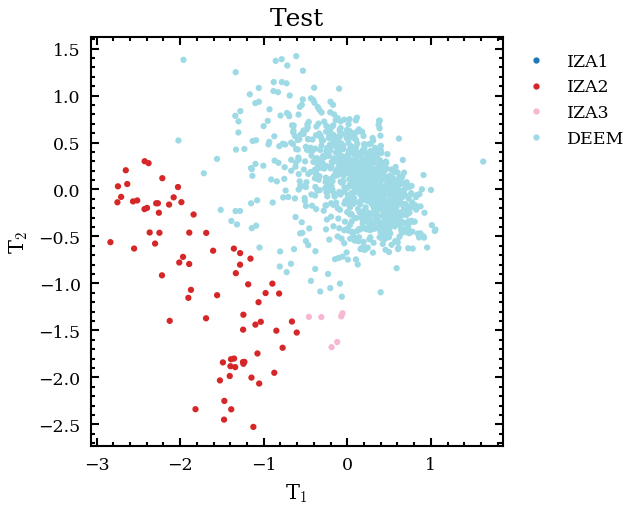

In [133]:
plt.scatter(T_test[n_iza_test:, 0], T_test[n_iza_test:, 1],
            #c=Y_svm_test[n_iza_test:], cmap='tab20', vmin=1, vmax=4, zorder=2)
            c=class_kpcovr_test[n_iza_test:], cmap='tab20', vmin=1, vmax=4, zorder=2)
plt.scatter(T_test[0:n_iza_test, 0], T_test[0:n_iza_test, 1],
            #c=Y_svm_test[0:n_iza_test], cmap='tab20', vmin=1, vmax=4, zorder=3)
            c=class_kpcovr_test[0:n_iza_test], cmap='tab20', vmin=1, vmax=4, zorder=3)
handles = [Line2D([0], [0], c=plt.get_cmap('tab20')(0.0), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(0.33), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(0.67), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(1.0), marker='o', linewidth=0)]
labels = ['IZA1', 'IZA2', 'IZA3', 'DEEM']
plt.legend(handles=handles, labels=labels, loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.xlabel(r'T$_1$')
plt.ylabel(r'T$_2$')
plt.title('Test')

plt.savefig('../Results/6.0/svm-kpcovr-test_test.png', bbox_inches='tight')

plt.show()

## Prep a chemiscope